## Improving from last time

How to improve accuracy:

- Data augmentation
- Train for *slightly* longer: risk danger of overfitting
- Learning rate: `0.01`


## Set up

Getting data from kaggle competition. Followed instructions here:
https://www.kaggle.com/general/74235

In [ ]:
# Required packages
! pip install -q torch
! pip install -q fastai
! pip install -q timm
! pip install -q nbdev
# Restart runtime

# Download data from kaggle
! pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c paddy-disease-classification
! unzip paddy-disease-classification.zip
#! unzip paddy-disease-classification.zip -d /workspaces/cv_fast_ai/data/paddy_classification

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

The `vision` module of the fastai library contains all the necessary functions to `define a Dataset` and `train a model` for `computer vision tasks`: https://docs.fast.ai/vision.core.html

A little exploration of images there:

fastai utilizes the Pillow library to open images and apply transforms. To open up any image using Pillow inside the fastai library, we have `PILImage.create`: https://walkwithfastai.com/vision.intro

In [ ]:
import fastai
from fastai.vision.all import*
import timm
import nbdev
# Path to data
path = Path()
train_path = path / 'train_images'
train_files = get_image_files(train_path)


# Obtain dimensions of image
img = PILImage.create(train_files[0])
img
print(img.size)

(480, 640)


## Data augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different but do not change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective
warping, brightness changes, and contrast changes. This is typically passed to the `data loader` and applied to all images in a batch.

### Image data loader
Allows one to load and preprocess (e.g normalize) data in batches for a model: https://docs.fast.ai/vision.data.html#imagedataloaders . Similar to image_data_loaders in Keras?

`item_tfms`: one or several transforms applied to the items before batching them e.g resizing such that all images going to a batch are of same size. We typically Crop full width or height

In deep learning we don’t feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform that will resize these images to the same size. `Resize` **crops** the images to fit a square shape of the size requested. This can lead to loss of info hence we typically squish/strech/pad the results.

`batch_tfms`: one or several transforms applied to the batches once they are formed.

In [ ]:
# See different data aumentation that will be applied
aug_transforms(size = 224, min_scale = 0.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

`RandomResizedCropGPU`: At each epoch, a random part of the image is selected and cropped. Hence model will learn to focus on, and recognize, different features in our
images.

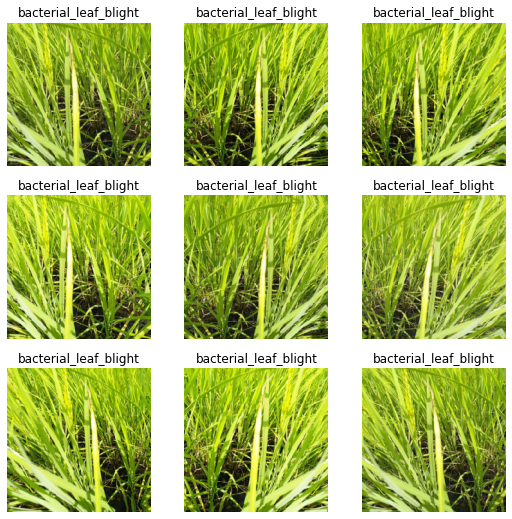

In [ ]:
# Preprocess images: expects a path to train folder
dls = ImageDataLoaders.from_folder(train_path, valid_pct = 0.2, item_tfms = Resize(480, method='squish'),
                                   # Imgnet dim: 224
                                   batch_tfms= aug_transforms(size = 224, min_scale = 0.75))

# Show preprocessing of a sample image
dls.show_batch(unique = True)

### Create model


Which image models are the best?: https://www.kaggle.com/code/jhoward/which-image-models-are-best

`timm`: a collection of CV models, similar to Hugging face transformers?
https://timm.fast.ai/

In [ ]:
import timm
timm.__version__
timm.list_models('convnext*')


['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

`Learner`: Group together a model, some dls and a loss_func to handle training. Sounds like a `workflow` in `TidyModels`?

In [ ]:
# Stack preprocessor, model, loss_func
workflow = vision_learner(dls = dls, arch = 'convnext_small_in22k', metrics = error_rate).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


## Train/Fine-tune model

When we call the fine_tune method, fastai does two things:

- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all the layers, and trains them for the number of epochs requested

SuggestedLRs(minimum=0.010000000149011612, steep=0.010964781977236271, valley=0.0008317637839354575, slide=0.0030199517495930195)

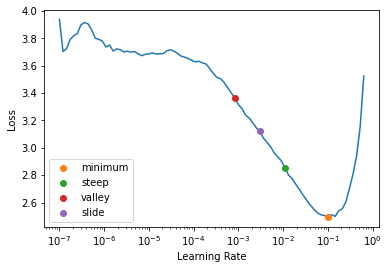

In [ ]:
# Explore different learning rates
workflow.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
# ??workflow.fine_tune
workflow.fine_tune(epochs = 12, base_lr = 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.093668,0.618143,0.195099,01:58


epoch,train_loss,valid_loss,error_rate,time
0,0.464807,0.295284,0.098030,02:04
1,0.370086,0.257660,0.087938,02:05
2,0.321222,0.227460,0.063912,02:07
3,0.285078,0.211732,0.067275,02:06
4,0.211529,0.167973,0.051418,02:06
5,0.177214,0.140873,0.036040,02:07
6,0.126679,0.132313,0.041326,02:05
7,0.094910,0.089715,0.025469,02:05
8,0.067142,0.083547,0.020663,02:05
9,0.057376,0.072503,0.017780,02:05


Here's how we would replicate predictions and error rate on validation set for the last epoch

In [ ]:
probs, targs = workflow.get_preds(dl = dls.valid)
error_rate(probs, targs)

TensorBase(0.0163)

One thing to note is that on the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen. This center cropping could be problematic since the model could miss some important aspects of the image during inference. One solution is to use `Test Time Augmentation`. In this technique during inference, multiple versions of the image are created and then the average/maximum of the predictions are taken. Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy. Let's see whether this would work in our case:

> Works well without `squish` 


In [ ]:
# Return predictions using TTA
probs, targs = workflow.tta(dl = dls.valid)
error_rate(probs, targs)

TensorBase(0.0130)

There was a reduction in the error rate, so a step in the right direction. We'll go forward with `tta` instead of `get_preds` for now.

## Export the workflow (dls + model)

In [ ]:
workflow.path = path
workflow.export("convnext_small_12.pkl")

## Make predictions on test set

Now that we have a basic model, let's make predictions on the test set.

For the test set, we'll use the `test data loader`: a data loader for inference.

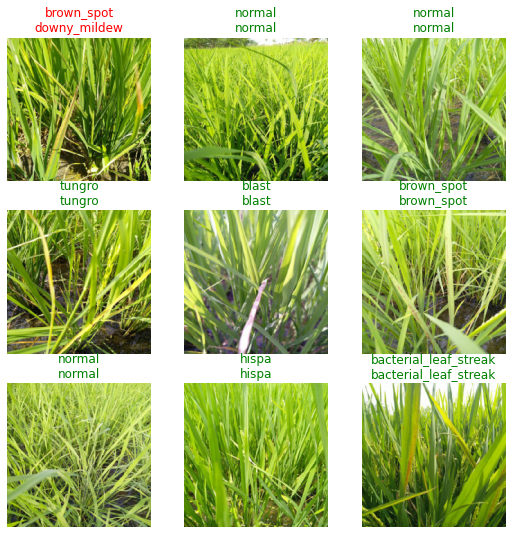

In [ ]:
# Test items
test_files = get_image_files(path / 'test_images')
test_files.sort()

# Create a test dataloader using validation transforms of dls
test_dl = dls.test_dl(test_files)

# Show batch
#test_dl.show_batch()

# Return predictions using TTA
probs, targs =workflow.tta(dl = test_dl)
#preds = workflow.get_preds(dl = test_dl, with_decoded = True)

# Show results
workflow.show_results()


In [ ]:
# Convert probabilities to integer labels
idxs = probs.argmax(dim = -1)

# Convert predictions to raw strings
idxs = pd.Series(idxs, name="idxs")
idx2tag = dict(enumerate(dls.vocab))
results = idxs.map(idx2tag)
results.head()


0     hispa
1    normal
2     blast
3     blast
4     blast
Name: idxs, dtype: object

In [ ]:
# Prepare data for kaggle submission
ss = pd.read_csv("sample_submission.csv")
ss["label"] = results
ss.to_csv("submission_2.csv", index = False)

In [ ]:
# Inspect submission
!head submission_2.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [ ]:
# # Non-TTA version

# # Test files
# test_files = get_image_files(path / 'test_images')
# test_files.sort()
# # Inference data loader
# test_dl = dls.test_dl(test_files)
# # test_dl.show_batch()

# # Make predictions
# preds = learn.get_preds(dl = test_dl, with_decoded = True)

# # Extract probabilities and predictions
# probs, _, idxs = preds

# # Obtain raw string predictions
# idxs = pd.Series(idxs.numpy(), name = "idxs")
# idx2tag = {idx: tag for idx, tag in enumerate(dls.vocab)}
# results = idxs.map(idx2tag)
# results.head()